In [15]:
import pandas as pd
import torch
import os
from torch.utils.data import Dataset,DataLoader
import numpy as np
from skimage import io    
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix                                                                                      

In [16]:
# Classes

classes = ['airplane','bird','car','cat','deer','dog','horse','monkey','ship','truck']     # index of entry for a class represents its class label

In [17]:
# Dataset and Preprocessing

class stl10_dataset(Dataset):
    
    def __init__(self,txt_file_loc,img_root_loc,transform_indicator=False):
       self.text_df = pd.read_csv(txt_file_loc,delimiter=' ',header=None,names=['path','class'])
       self.img_root_loc = img_root_loc
       self.transform_indicator = transform_indicator

       
    def __len__(self):
        data_length = self.text_df.shape[0]
        return data_length

    def __getitem__(self,idx):
        img_path = os.path.join(self.img_root_loc,self.text_df.iloc[idx,0])
        image = io.imread(img_path)                                                # image read as H x W x C numpy array (96 x 96 x 3)
        image_class = self.text_df.iloc[idx,1]                                     # image class is a numpy scalar
        if self.transform_indicator == True:
            transform_tensor = transforms.ToTensor()
            image_tensor = transform_tensor(image)                                 # we now have C x H x W tensor (3 x 96 x 96)
            transform_size = transforms.Resize((32,32))              
            image_size = transform_size(image_tensor)                              # we now have 3 x 32 x 32 tensor
            max_tensor = torch.max(torch.max(image_size,1).values,1).values
            min_tensor = torch.min(torch.min(image_size,1).values,1).values
            transform_range = transforms.Normalize(min_tensor,max_tensor-min_tensor)
            image_range = transform_range(image_size)                              # entire image range set to [0,1]
            std_mean = torch.std_mean(image_range,(1,2),unbiased=True)
            transform_normalize = transforms.Normalize(std_mean[1],std_mean[0])
            image = transform_normalize(image_range)                               # final image after normalizing, tensor of C x H x W (3 x 32 x 32)
            image_class = torch.from_numpy(np.array(image_class))                  # final image class, tensor scalar indicating class
        sample = {'image':image,'image_class':image_class}
        return sample

In [18]:
# Dataloader (Train)

batch_size = 128
num_workers = 0
train_dataset = stl10_dataset('splits/train.txt','',transform_indicator=True)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [19]:
# Neural Network

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5,stride=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5,stride=1)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)                    # this means that input should be always batched into N x C x H x W format irrespective of how many samples are there in a batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [20]:
# Loss, Optimizer and Scheduler

initial_learning_rate = 1e-3
decay_rate = 0.5
lr_update_step = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(),lr=initial_learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=lr_update_step,gamma=decay_rate)

In [7]:
# Training (and Validating)

total_epochs = 25
validation_test_interval = 5
validation_dataset = stl10_dataset('splits/val.txt','',transform_indicator=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=batch_size,shuffle=False,num_workers=num_workers)
batch_iter = -1
all_batch_loss = []
all_epoch_loss = []
all_val_loss = []
for epoch in range(total_epochs):
   net.train()
   epoch_loss = 0
   for i,data_batch in enumerate(train_dataloader):
      batch_iter = batch_iter + 1                                 # batch_iter shows how many batches have been optimized, over all epochs (index starting at 0)
      input_batch = data_batch['image']
      target_batch = data_batch['image_class']
      optimizer.zero_grad()
      output_batch = net(input_batch)
      loss = criterion(output_batch,target_batch)
      epoch_loss = epoch_loss + loss.item()
      all_batch_loss.append(loss.item())                          # all_batch_loss contains loss obtained for each batch, over all epochs
      loss.backward()
      optimizer.step()
   all_epoch_loss.append(epoch_loss/(i+1))                        # stores epoch loss per epoch (averaged over batches per epoch)
   if ((epoch+1) % (validation_test_interval)) == 0:              # after training for every validation_test_interval epochs, testing on validation set to check overfitting
      net.eval()
      val_loss = 0
      with torch.no_grad():
         for i,val_batch in enumerate(validation_dataloader):
            val_input = val_batch['image']
            val_target = val_batch['image_class']
            val_output = net(val_input)
            loss = criterion(val_output,val_target)
            val_loss = val_loss + loss
      all_val_loss.append(val_loss/(i+1))                         # after validation_test_intervals, all_val_loss contains loss averaged over all the batches in validation_dataset (equivalent to epoch loss, calculated at set training epoch intervals, calculated over equal batch sizes in the validation dataset)  
   scheduler.step() 

# neural network state could be saved in a dictionary, however not needed here

In [8]:
# Testing

test_dataset = stl10_dataset('splits/test.txt','',transform_indicator=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_workers)
net.eval()
full_target_list = []
full_classified_list = []
test_loss = 0
with torch.no_grad():
    for i,test_batch in enumerate(test_dataloader):
        input_batch = test_batch['image']
        target_batch = test_batch['image_class']
        output_batch = net(input_batch)
        loss = criterion(output_batch,target_batch)
        test_loss = test_loss + loss
        classified_batch = []
        for j in np.arange(output_batch.shape[0]):
            output_vector = output_batch[j,:]
            output_class = torch.argmax(output_vector)
            classified_batch.append(output_class)
        classified_tensor = torch.tensor(classified_batch)
        full_target_list = full_target_list + target_batch.tolist()
        full_classified_list = full_classified_list + classified_tensor.tolist()
test_loss = test_loss/(i+1)
confusion_arr = confusion_matrix(full_target_list,full_classified_list)
classes_pred = [str(i)+str('_pred') for i in classes]
classes_true = [str(i)+str('_true') for i in classes]
confusion_df = pd.DataFrame(confusion_arr,index=classes_true,columns=classes_pred)
classes_acc = [str(i)+str('_acc') for i in classes]
class_acc_df = pd.DataFrame(0,index=classes_acc,columns=['accuracy'])
for i in np.arange(len(classes)):
    class_acc_df.iloc[i,0] = confusion_df.iloc[i,i]/(confusion_df.iloc[i,:].sum())

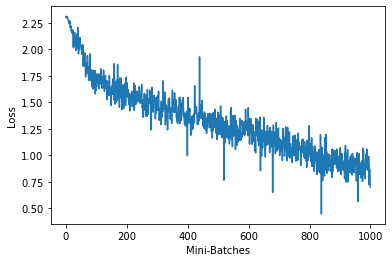

In [9]:
# Metrics and Visualizations

plt.plot(np.arange(len(all_batch_loss)),all_batch_loss)
plt.xlabel('Mini-Batches')
plt.ylabel('Loss')
plt.show()

Plot of Loss versus Mini-Batches for all the Mini-Batches during training - as seen here, on an average, the loss does drop, however I don't precisely understand why the spikes appear here.

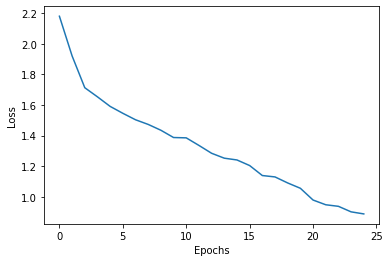

In [10]:
plt.plot(np.arange(len(all_epoch_loss)),all_epoch_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

As seen in the above curve, the training loss consistently reduces as a function of the number of epochs - also the sharp points are removed possibly due to averaging the batch losses per epoch.

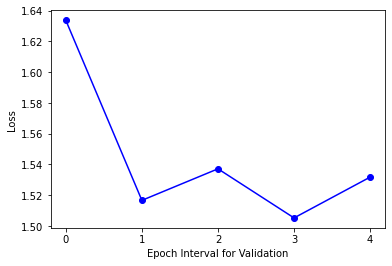

In [11]:
plt.plot(np.arange(len(all_val_loss)),all_val_loss,'-bo')
plt.xticks(np.arange(len(all_val_loss)))
plt.xlabel('Epoch Interval for Validation')
plt.ylabel('Loss')
plt.show()

As can be seen from the above curve, we have clearly over-fitted the data - extremely so. I've fixed the number of epochs at 100 for this code portion, however based on the above curve, it seems that the ideal training epochs shouldn't be more than 15-20 (each point in the curve corresponds to 5 training epochs)

Just for comparsion, this main experiment iteration with 100 total epochs will be kept - specifically for comparison with another version of the main experiment with total training epochs around 15 to 20.

Ideally, when the validation loss starts to rise or increase post a particular epoch, the training should then be terminated at that epoch. We have used the approach of fixed epoch termination, however, modifying the code to perform a validation error based termination wouldn't be that difficult. 

Another version of the main experiment with ~15 to 20 training epochs will also be performed.

In [12]:
print(test_loss)

tensor(1.4996)


The test loss can definitely be reduced by training the network for fewer epochs - at least according to what the validation curve suggests.

In [13]:
print(confusion_df)
confusion_df.to_csv('Variation_Experiment/confusion_matrix.csv')

               airplane_pred  bird_pred  car_pred  cat_pred  deer_pred  \
airplane_true            362         18        19         3          6   
bird_true                 27        155        17        67         58   
car_true                  18          9       304        15          8   
cat_true                   7         43        19       150         63   
deer_true                 19         28         9        58        232   
dog_true                   5         42         4        71         66   
horse_true                 6         17         7        39         60   
monkey_true                3         40         4        65         41   
ship_true                 50          0        24         9          5   
truck_true                27         11       105        21         11   

               dog_pred  horse_pred  monkey_pred  ship_pred  truck_pred  
airplane_true         4           3            3         34          48  
bird_true            40          34  

The confusion dataframe is as specified above.

In [14]:
print(class_acc_df)
class_acc_df.to_csv('Variation_Experiment/accuracy.csv')

              accuracy
airplane_acc     0.724
bird_acc         0.310
car_acc          0.608
cat_acc          0.300
deer_acc         0.464
dog_acc          0.214
horse_acc        0.560
monkey_acc       0.410
ship_acc         0.614
truck_acc        0.538


The class accuracy obtained is decent - but improvement is definitely possible.